In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# del os.environ["WANDB_DISABLED"]

In [46]:
import os
import shlex

import datasets
import torch
from transformers import AutoTokenizer, HfArgumentParser, set_seed
from transformers.trainer_utils import get_last_checkpoint

from collator import CustomCollator
from data_helpers import load_dpr_corpus, NQ_DEV, NQ_TRAIN
from models import load_encoder_decoder, load_embedder_and_tokenizer, InversionModel
from run_args import ModelArguments, DataTrainingArguments, TrainingArguments
from tokenize_data import tokenize_function
from trainers import InversionTrainer

del os.environ["WANDB_DISABLED"]
#############################################################################

DEFAULT_ARGS_STR = '--per_device_train_batch_size 128 --per_device_eval_batch_size 256 --max_seq_length 64 --model_name_or_path t5-base --embedder_model_name dpr --num_repeat_tokens 16 --embedder_no_grad True --exp_group_name mar9-freeze --learning_rate 0.0002 --freeze_strategy none --num_train_epochs 12 --max_eval_samples 400 --eval_steps 8000 --warmup_steps 6000 --bf16=1 --use_wandb=1'
DEFAULT_ARGS = shlex.split(DEFAULT_ARGS_STR)
DEFAULT_ARGS += ['--use_wandb', '0']
DEFAULT_ARGS += ['--bf16', '1']

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=DEFAULT_ARGS)

checkpoint = '/home/jxm3/research/retrieval/inversion/saves/c9a30cba01655d513e46040f949f6da7'
training_args = torch.load(os.path.join(checkpoint, 'training_args.bin'))
training_args.use_wandb = False

set_seed(training_args.seed)

#############################################################################
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    padding=True,
    truncation='max_length',
    max_length=model_args.max_seq_length,
)
embedder, embedder_tokenizer = load_embedder_and_tokenizer(
    name=model_args.embedder_model_name
)
model = InversionModel(
    embedder=embedder,
    embedder_tokenizer=embedder_tokenizer,
    tokenizer=tokenizer,
    encoder_decoder=load_encoder_decoder(
        model_name=model_args.model_name_or_path
    ),
    num_repeat_tokens=model_args.num_repeat_tokens,
    embedder_no_grad=model_args.embedder_no_grad,
    freeze_strategy=model_args.freeze_strategy,
)

#############################################################################

text_column_name = "text"

raw_datasets = datasets.DatasetDict({
    "train": load_dpr_corpus(NQ_TRAIN),
    "validation": load_dpr_corpus(NQ_DEV),
})
column_names = list(raw_datasets["train"].features)
tokenized_datasets = raw_datasets.map(
    tokenize_function(tokenizer, embedder_tokenizer, text_column_name, model_args.max_seq_length),
    batched=True,
    num_proc=training_args.dataloader_num_workers,
    remove_columns=column_names,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on dataset",
)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

if data_args.max_eval_samples is not None:
    max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples))


#############################################################################

# Initialize our Trainer
trainer = InversionTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=CustomCollator(tokenizer=tokenizer),
)

# *** Evaluation ***
# checkpoint = get_last_checkpoint('/home/jxm3/research/retrieval/inversion/saves/32aae4b3d898f7a7bc70564258c08f16') # a checkpoint
trainer._load_from_checkpoint(checkpoint)

os.environ["WANDB_DISABLED"] = "true"
max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)

metrics = trainer.evaluate()
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

print("metrics:", metrics)

PyTorch: setting up devices
Could not locate the tokenizer configuration file, will try to use the model config instead.


Set train_args.dataloader_num_workers = 4


loading configuration file config.json from cache at /home/jxm3/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "max_length": 64,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


Using cuda_amp half precision backend
Loading model from /home/jxm3/research/retrieval/inversion/saves/c9a30cba01655d513e46040f949f6da7.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"                                               


metrics: {'eval_loss': 2.6037161350250244, 'eval_bleu_score': 7.5013414898752355, 'eval_accuracy': 0.481796875, 'eval_perplexity': 13.513864183564078, 'eval_runtime': 52.9559, 'eval_samples_per_second': 7.553, 'eval_steps_per_second': 0.944, 'eval_samples': 400}


In [47]:
from utils import embed_all_tokens

device = torch.device('cuda')
trainer.model.embedded_tokens = embed_all_tokens(trainer.model, embedder_tokenizer).to(device)

                                                                                                                                               <00:00, 44617.45it/s]

all_token_embeddings.shape: torch.Size([30522, 768])


In [81]:
trainer.args.per_device_eval_batch_size = 128

In [112]:
from tqdm.notebook import tqdm

data = []
for alpha in tqdm([0.9, 0.99, .999, 0.9999]): # , 0.999, 0.9999]):
    for temperature in [20, 10, 2, 1, 1e-1, 1e-2]:
        trainer.model.token_decode_alpha = alpha
        trainer.model.token_decode_temperature = temperature
        # print('** temperature **', temperature)
        metrics = trainer.evaluate()
        metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))
        metrics["alpha"] = alpha
        metrics["temperature"] = temperature
        data.append(metrics)


  0%|          | 0/4 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born October 16, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy 


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born October 23, 1969) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'5" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then reacted to by the animal's mate, who was more receptive to the stimulus. The results of this experiment show that the behavior
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful an


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born April 23, 1971) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'5" forward, Jackson played college basketball for the University of Miami. He was named to the NBA All-Star Game in 2005 and 2006
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the animal was rewarded, the emotions returned to the same state. This is called the "response phase". In the "response phase", the emotions returned to the same state, but the behaviors were different. In the "response phase", the behaviors
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy after the shocks stopped alto


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Nasha Jackson Nasha Jackson (born April 23, 1971) is an American retired professional basketball player for the Miami Heat of the National Basketball Association (NBA). A 6-foot-7 forward, Jackson played college basketball for the University of Florida. He was named NBA All-Star Game MVP in 2005 and 2006, and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the trial, the animal returned to the same behavior as before. This behavior was described as "extremely fuzzy". Animals that were punished for their actions continued to behave in a fuzzy manner, and the behaviors of the antagonists were progressively fuzzy. Animals that were punished for their actions continued
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]
                                                                                                                                               

Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Hernandez Gonzalez Toledo Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



Comparison ensue ensue chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chron


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]
                                                                                                                                               

Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Hernandez Gonzalez Toledo Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



Comparison ensue ensue chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chron


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born October 23, 1969) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then reacted to by the animal's mate, who was more receptive to the stimulus. The results of this experiment show that the behavior
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful an


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Nasha Jackson Nasha Jackson (born April 23, 1971) is an American retired professional basketball player for the Miami Heat of the National Basketball Association (NBA). A 6-foot-7 forward, Jackson played college basketball for the University of Miami. He was named to the NBA All-Star Game in 2005 and 2006,
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the trial, the animal returned to the same behavior as before. This behavior was described as "extremely happy". Animals that were punished for their actions were more happy, and those who were punished for their actions were more happy. This correlates with the heightened emotions of the animal, which are
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]
                                                                                                                                               

Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Ibrahim Hernandez Gonzalez Toledo Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad Trinidad
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



Comparison ensue ensue chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chronological chron


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born October 23, 1969) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then reacted to by the animal's mate, who was more receptive to the stimulus. The results of this experiment show that the behavior
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful an


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.27s/it]
                                                                                                                                               

Nasha Jackson Nasha Jackson (born April 23, 1971) is an American retired professional basketball player for the Miami Heat of the National Basketball Association (NBA). A 6-foot-7 forward, Jackson played college basketball for the University of Miami. He was named to the NBA All-Star Game in 2005 and 2006,
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the trial, the animal returned to the same behavior as before. This behavior was described as "extremely happy". Animals that were punished for their actions were more happy, and those who were punished for their actions were more happy. This correlates with the heightened emotions of the animal, which are
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the behavior was more receptive to the stimulus. The results showed that the behavior of the receptive animal was receptive to the stimulus, and the behavior of the receptive animal was
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful and happy a


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born August 6, 1968) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then receptive to the stimulus, and the reward was more intense. The results of this experiment show that the animals who were receptive to the
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               ***** Running Evaluation *****
  Num examples = 400
  Batch size = 128

generating from val: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]
                                                                                                                                               

Shaun Jackson Shaun Jackson (born October 23, 1969) is an American retired professional basketball player for the Atlanta Hawks of the National Basketball Association (NBA). A 6'4" forward, Jackson played college basketball for the University of Miami. He was named to the All-American team in his senior season and
Alonzo Mourning Alonzo Harding Mourning Jr. (born February 8, 1970) is an American retired professional basketball player, who played most of his 15-year National Basketball Association (NBA) career for the Miami Heat. Nicknamed "Zo", Mourn



After the second experiment, the animals were more receptive to the stimulus, and the reward was more intense. The behavior of the animals was then reacted to by the animal's mate, who was more receptive to the stimulus. The results of this experiment show that the behavior
Then, when they stopped the stimuli, the dogs became stealthy and cautious. The experiment continued, and after many stimuli, the dogs went from unhappy to joyful an


generating from train:   0%|                                                                                         | 0/41656 [00:00<?, ?it/s]
                                                                                                                                               

In [118]:
import pandas as pd
import seaborn as sns

full_df = pd.DataFrame(data)
full_df.head()

,eval_loss,eval_bleu_score,eval_accuracy,eval_perplexity,eval_runtime,eval_samples_per_second,eval_steps_per_second,eval_samples,alpha,temperature
0,2.600928,7.392061,0.481812,13.476233,9.3616,42.728,0.427,400,0.9,20.0
1,2.600928,7.300281,0.481812,13.476233,7.9090,50.576,0.506,400,0.9,10.0
2,2.600928,6.641757,0.481812,13.476233,7.9879,50.076,0.501,400,0.9,2.0
3,2.600928,5.136437,0.481812,13.476233,8.0066,49.959,0.500,400,0.9,1.0
4,2.600928,0.003094,0.481812,13.476233,7.9352,50.408,0.504,400,0.9,0.1


In [119]:
# baseline eval_bleu_score 7.307456928008692

In [120]:
full_df.pivot('alpha', 'temperature', 'eval_bleu_score')

temperature,0.01,0.10,1.00,2.00,10.00,20.00
alpha,,,,,,
0.9000,0.003094,0.003094,5.136437,6.641757,7.300281,7.392061
0.9900,0.003095,5.633824,7.320665,7.402854,7.313378,7.284537
0.9990,5.636184,7.349406,7.313378,7.284928,7.286642,7.306227
0.9999,7.349406,7.313378,7.286642,7.306227,7.307457,7.307457


<AxesSubplot:xlabel='temperature', ylabel='alpha'>

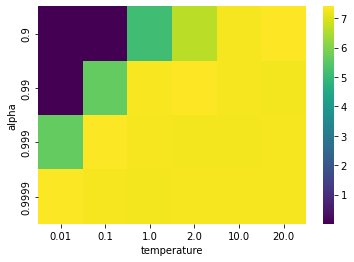

In [124]:
df = full_df.pivot('alpha', 'temperature', 'eval_bleu_score')
sns.heatmap(data=df, cmap='viridis')